In [234]:
import keras
from IPython import display
from PIL import Image
import glob
import pandas as pd
import numpy as np
from ImageRecognition.utils.DataGenerator import get_feature_description
feature_description = get_feature_description()

model = keras.models.load_model('../Models/csgid-image-rec.h5')
minstrel_dir = "../Minstrel-Screens/*/*"

def image_preprocess(impath):
    image = Image.open(impath)
    crop_size = min(image.size)
    left = (image.size[1]-crop_size)//2
    right = image.size[1]-(image.size[1]-crop_size)//2
    bottom = (image.size[0]-crop_size)//2
    top = image.size[0]//2+crop_size//2
    image = image.crop((left, bottom, right, top))
    image = image.resize((299,299),Image.ANTIALIAS)
    image = np.asarray(image)
    return image

def image_getter(plate_dir):
    image_folders = glob.glob(plate_dir)
    wells = pd.DataFrame(glob.glob(image_folders[1]+"/*"), columns = ["filepath"])
    wells = wells[wells["filepath"].str.contains("_E0_")]
    wells = wells.reset_index().drop(columns = "index")
    wells["image"] = wells['filepath'].apply(lambda x: image_preprocess(x))
    return wells

def predict(image, classifier):
    #for each image, load, resize and predict. (morphological?)
    prediction = classifier.predict(image)
    return prediction

ImportError: cannot import name 'get_feature_description' from 'ImageRecognition.utils.DataGenerator' (/home/grant/PycharmProjects/CSGID/ImageRecognition/utils/DataGenerator.py)

In [152]:
wells = image_getter(minstrel_dir)
test_image = wells.iloc[0]['image']

In [166]:
# Much of the code used here is based on: https://keras.io/examples/keras_recipes/tfrecord/
import tensorflow as tf
from ImageRecognition.utils.DataGenerator import get_dataset
from ImageRecognition.utils.Inceptionv4 import create_model
import glob

train_list = glob.glob('../train-jpg/*')[0:2]
test_list = glob.glob('../test-jpg/*')[0:1]
valid_list = test_list

# Tuning and training params:
BATCH_SIZE = 100
IMAGE_SIZE = [100, 100, 3]

print("Train Files: ", len(train_list))
print("Test Files: ", len(test_list))

train_dataset = get_dataset(train_list, batch_size=BATCH_SIZE, im_size=IMAGE_SIZE)
valid_dataset = get_dataset(test_list, batch_size=BATCH_SIZE, im_size=IMAGE_SIZE)
test_dataset = get_dataset(test_list, labeled=False, batch_size=BATCH_SIZE, im_size=IMAGE_SIZE)

Train Files:  2
Test Files:  1


In [167]:
import matplotlib.pyplot as plt
test_image, test_label = next(iter(valid_dataset))

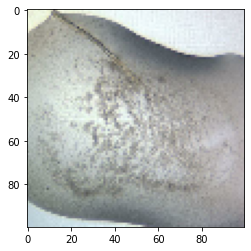

In [168]:
test_pred = model.predict(test_image)
#plt.imshow(test_image[0].numpy()/255)

In [169]:
test_label.numpy()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [170]:
test_pred


array([[0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.12766936],
       [0.127

In [229]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def tfrecord_writer(filepath, label=5):
    image_string = open(filepath, 'rb').read()
    image_shape = tf.image.decode_jpeg(image_string).shape
    label = label
    feature = {
        "image/height": _int64_feature(image_shape[0]),  # image height in pixels
        "image/width": _int64_feature(image_shape[1]),  # image width in pixels
        "image/colorspace": _bytes_feature(bytes('RGB', encoding='utf8')),  # specifying the colorspace, always 'RGB'
        "image/channels": _int64_feature(3),  # specifying the number of channels, always 3
        "image/class/label": _int64_feature(label),  # specifying the index in a normalized classification layer
        "image/class/raw": _int64_feature(label),
        # specifying the index in the raw (original) classification layer
        "image/class/source": _int64_feature(5),
        # specifying the index of the source (creator of the image) - CSGID = 5
        "image/class/text": _bytes_feature(bytes(label)),
        # specifying the human-readable version of the normalized label
        "image/format": _bytes_feature(bytes("JPEG", encoding='utf8')),  # specifying the format, always 'JPEG'
        "image/filename": _bytes_feature(bytes(filepath, encoding='utf8' )),  # containing the basename of the image file
        "image/id": _bytes_feature(bytes(filepath, encoding='utf8')),  # specifying the unique id for the image
        "image/encoded": _bytes_feature(image_string),  # containing JPEG encoded image in RGB colorspace

    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [230]:
#Generate a dict of the well numbers and the image directories
image_labels = wells['filepath'].to_dict()
image_labels

{0: '../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_04_08_01_E0_99_025_001_RDI.jpg',
 1: '../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_05_08_01_E0_99_025_001_RDI.jpg',
 2: '../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_03_01_01_E0_99_025_001_RDI.jpg',
 3: '../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_03_03_01_E0_99_025_001_RDI.jpg',
 4: '../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_08_03_01_E0_99_025_001_RDI.jpg',
 5: '../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_02_08_01_E0_99_025_001_RDI.jpg',
 6: '../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_06_07_01_E0_99_025_001_RDI.jpg',
 7: '../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_10_08_01_E0_99_025_001_RDI.jpg',


In [205]:
tfrecord_batch = wells["filepath"].apply(lambda x: tfrecord_writer(x))

In [221]:
#where to save it:
record_file = '../test_images.tfrecords'

ValueError: embedded null byte

In [231]:
#Write all the serialized images to file:
with tf.io.TFRecordWriter(record_file) as writer:
    for label, filename in image_labels.items():
        print(filename)
        print(label)
        tf_example = tfrecord_writer(filename, label)
        writer.write(tf_example.SerializeToString())

../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_04_08_01_E0_99_025_001_RDI.jpg
0
../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_05_08_01_E0_99_025_001_RDI.jpg
1
../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_03_01_01_E0_99_025_001_RDI.jpg
2
../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_03_03_01_E0_99_025_001_RDI.jpg
3
../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_08_03_01_E0_99_025_001_RDI.jpg
4
../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_02_08_01_E0_99_025_001_RDI.jpg
5
../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_06_07_01_E0_99_025_001_RDI.jpg
6
../Minstrel-Screens/C2019025/1/RMM3_01_429_ROBO_Test1_Clon1_C2_0000C2019025_001_201030_10_08_01_E0_99_025_001_RDI.jpg
7
../Minstrel-Screens/C2019025/1/RMM3_01_4

In [233]:
pred_dataset = get_dataset(record_file, batch_size=BATCH_SIZE, im_size=IMAGE_SIZE)
#Let's make sure we can read our files:
raw_example = tf.data.TFRecordDataset(record_file)
parsed_example = raw_example.map(lambda x: tf.io.parse_example(x, feature_description))

#Read our training data from parsed_example into a real dataset:
imlist = [] #Vectorized images
label_list = [] #Machine-readable labels
human_label_list = [] #Human-readable labels

for n in parsed_example:
  this_image = tf.io.decode_jpeg(n['image/encoded'].values.numpy()[0]) #Get image data from TFR
  this_image = tf.cast(this_image, tf.int16) #Downsampling to int16
  this_image = tf.image.resize_with_crop_or_pad(  #Downsampling by cropping to drop
      this_image, 600,600
      )
  this_image = tf.image.resize(this_image, (IMAGE_SIZE[0], IMAGE_SIZE[1])) #Downsampling by resizing image
  this_label = n['image/class/label'].values.numpy()[0] #Get image class number
  this_human_label = n['image/class/text'].values.numpy()[0] #Get image class name

  this_image = (np.array(this_image) / 255)
  imlist.append(this_image)
  label_list.append(this_label)
  human_label_list.append(this_human_label)

imlist = np.array(imlist)
label_list = np.array(label_list)
human_label_list = np.array(human_label_list)

NameError: in user code:

    <ipython-input-233-85c07666efed>:4 None  *
        parsed_example = raw_example.map(lambda x: tf.io.parse_example(x, feature_description))

    NameError: name 'feature_description' is not defined
